In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking


In [5]:
# Set dataset paths
dataset_path = "archive-20250222T171515Z-001/archive"
output_path = "processed_dataset"  # Output folder for processed images
os.makedirs(output_path, exist_ok=True)

# Load a few sample images from Positive (Labelled)
positive_path = os.path.join(dataset_path, "Positive", "Labelled")
sample_images = [os.path.join(positive_path, img) for img in os.listdir(positive_path)[:5]]  # First 5 images


In [6]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Step 1: Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Step 2: Enhance Contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_img = clahe.apply(gray)

    # Step 3: Noise Removal using Non-Local Means
    denoised_img = cv2.fastNlMeansDenoising(contrast_img, None, h=30, templateWindowSize=7, searchWindowSize=21)

    # Step 4: Adaptive Thresholding
    thresh_img = cv2.adaptiveThreshold(denoised_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Step 5: Final Contrast Enhancement
    final_img = clahe.apply(thresh_img)

    return img, gray, contrast_img, denoised_img, thresh_img, final_img


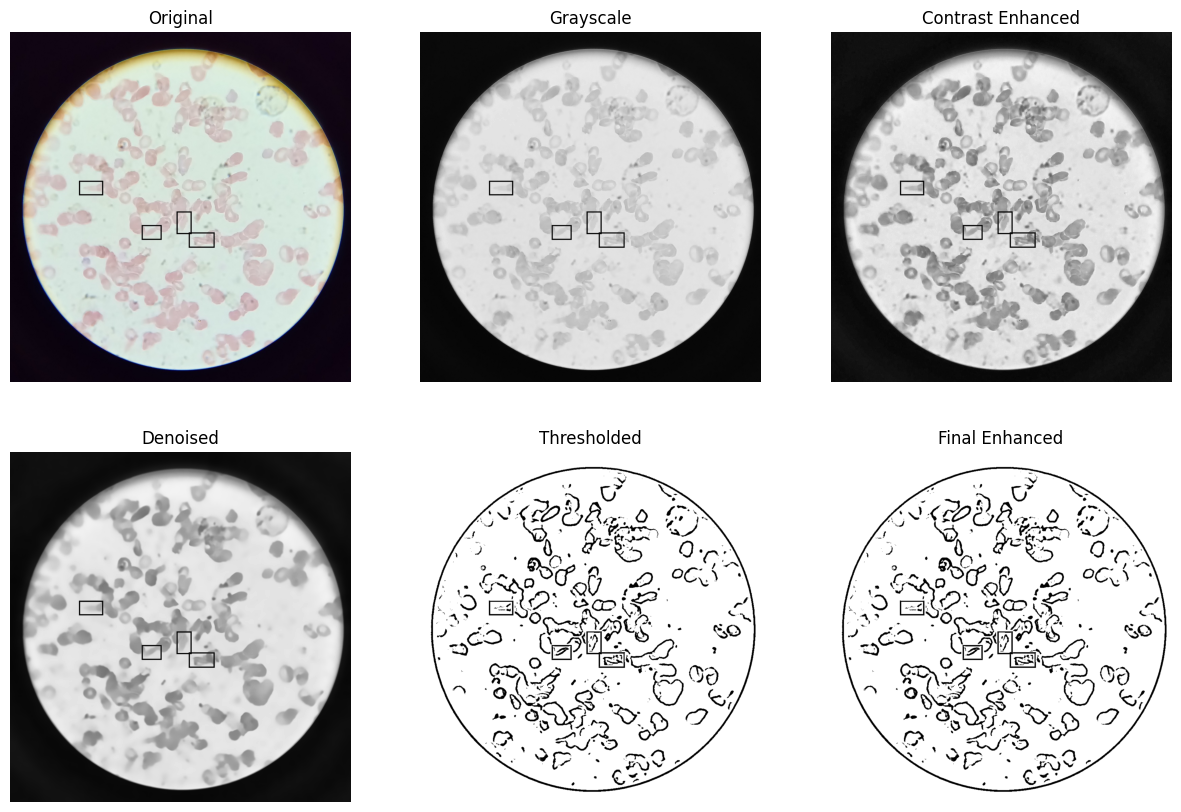

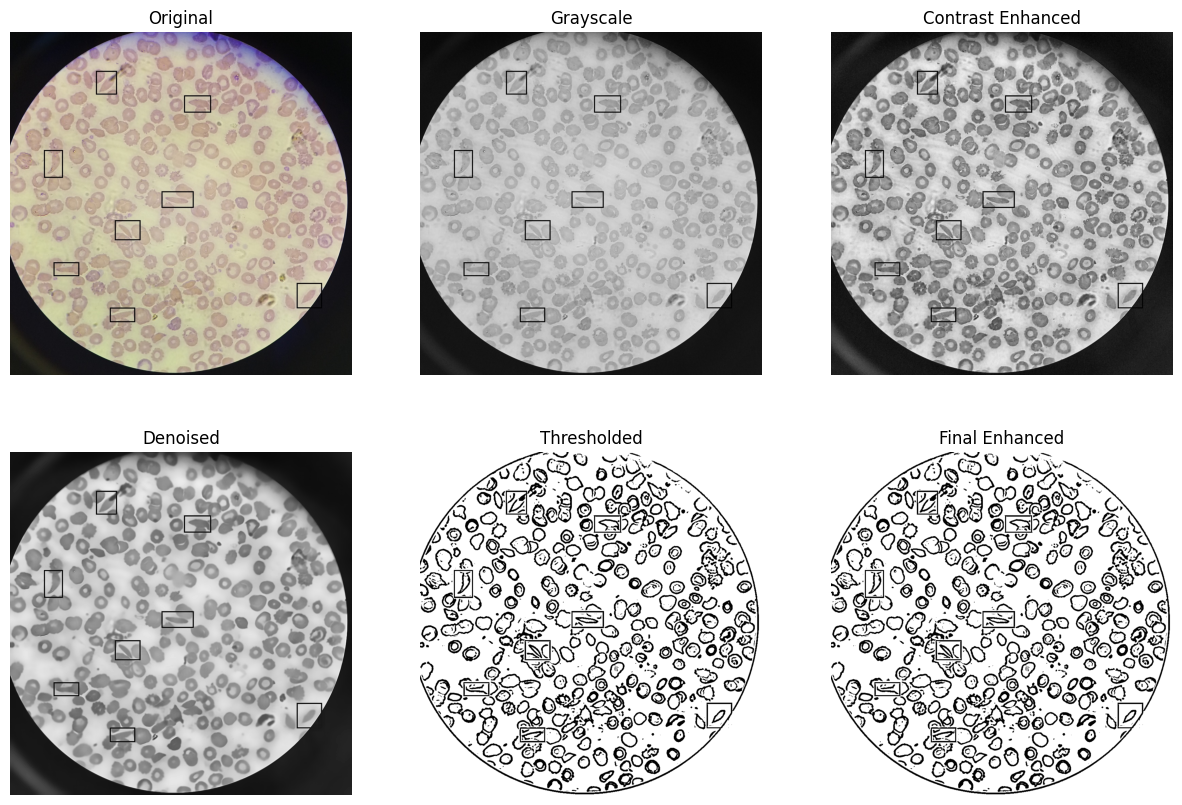

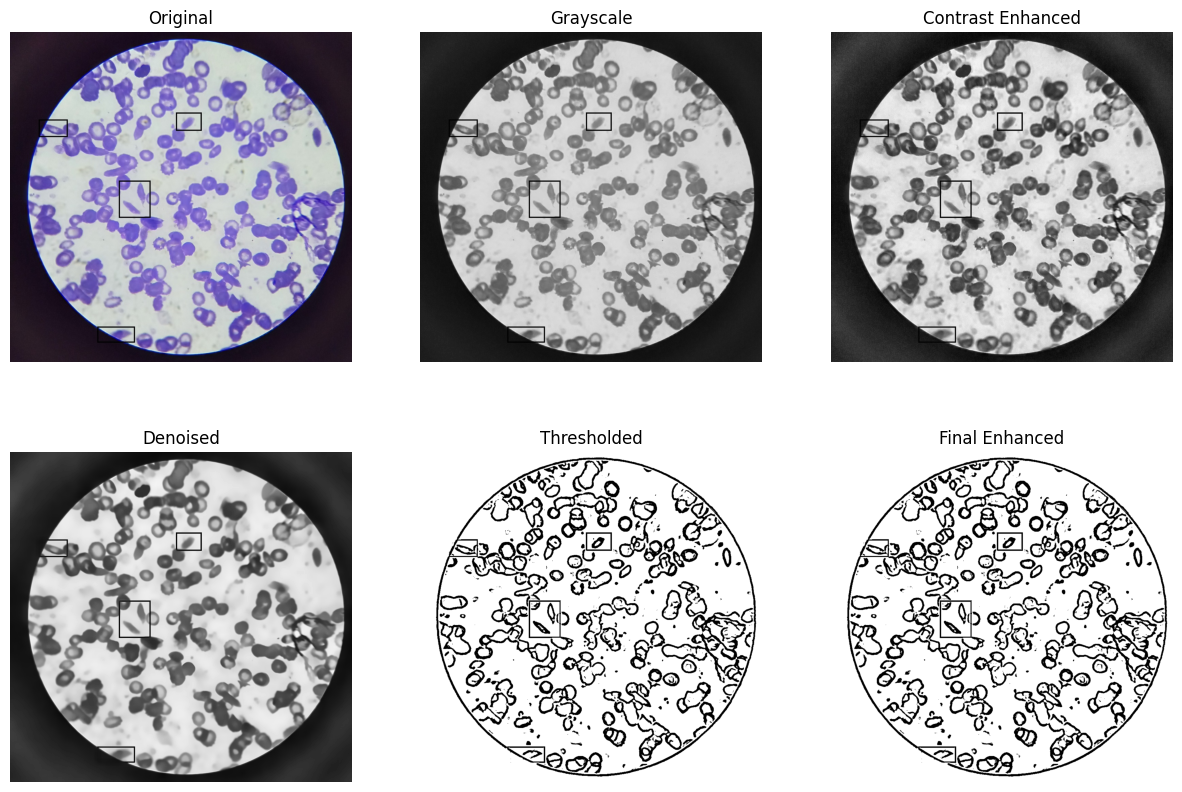

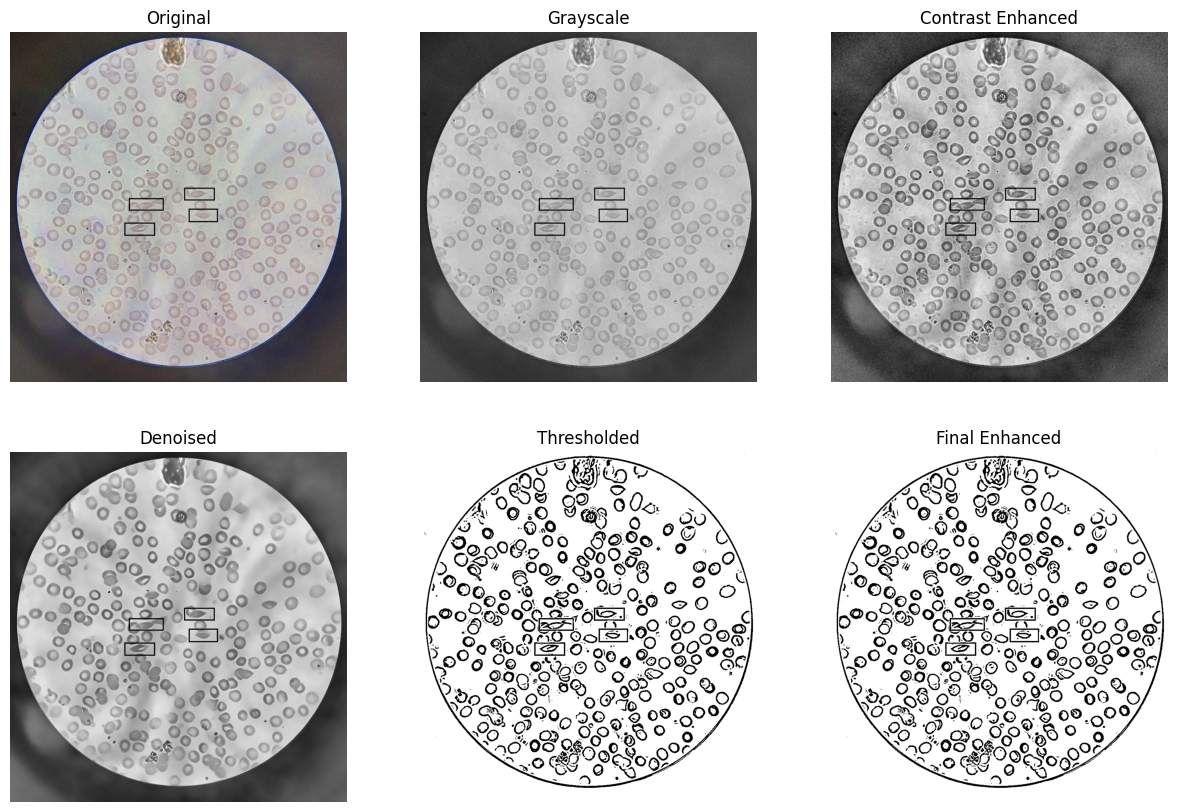

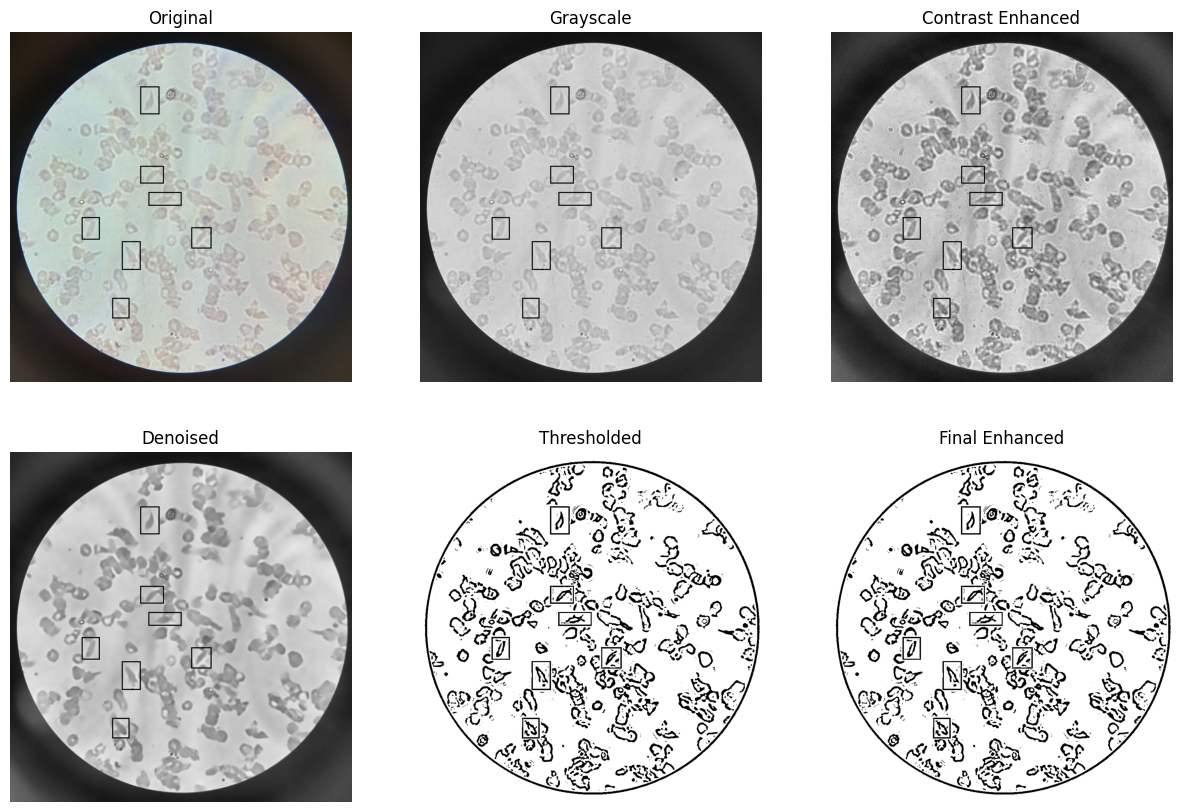

In [7]:
# Process and visualize first 5 images
for img_path in sample_images:
    img, gray, contrast_img, denoised_img, thresh_img, final_img = preprocess_image(img_path)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    images = [img, gray, contrast_img, denoised_img, thresh_img, final_img]
    titles = ["Original", "Grayscale", "Contrast Enhanced", "Denoised", "Thresholded", "Final Enhanced"]

    for ax, im, title in zip(axes.ravel(), images, titles):
        ax.imshow(im, cmap="gray" if len(im.shape) == 2 else None)
        ax.set_title(title)
        ax.axis("off")

    plt.show()


In [15]:
def process_and_save_images(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    # Ensure "Clear" folder is accessed properly
    if not os.path.isdir(input_folder):
        print(f"⚠️ Warning: {input_folder} is not a directory. Skipping...")
        return

    image_files = os.listdir(input_folder)

    for img_name in tqdm(image_files, desc=f"Processing {input_folder}"):
        img_path = os.path.join(input_folder, img_name)
        
        # Ensure only image files are processed
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            print(f"⚠️ Skipping non-image file: {img_name}")
            continue

        try:
            _, _, _, _, _, processed_img = preprocess_image(img_path)

            # Save processed image
            output_img_path = os.path.join(output_folder, img_name)
            cv2.imwrite(output_img_path, processed_img)

        except Exception as e:
            print(f"⚠️ Warning: Could not process {img_path}. Skipping... Error: {e}")

# Re-run processing with corrected path for "Negative"
for category in ["Negative", "Positive"]:
    category_path = os.path.join(dataset_path, category)
    output_category_path = os.path.join(output_path, category)

    if category == "Positive":  # Process both Labelled and Unlabelled
        for subfolder in ["Labelled", "Unlabelled"]:
            input_folder = os.path.join(category_path, subfolder)
            output_subfolder = os.path.join(output_category_path, subfolder)
            process_and_save_images(input_folder, output_subfolder)
    else:
        input_folder = os.path.join(category_path, "Clear")  # Access the "Clear" folder
        process_and_save_images(input_folder, output_category_path)

print("✅ Preprocessing complete! Processed images saved in:", output_path)


Processing archive-20250222T171515Z-001/archive\Negative\Clear: 100%|██████████| 147/147 [01:41<00:00,  1.45it/s]
Processing archive-20250222T171515Z-001/archive\Positive\Labelled: 100%|██████████| 422/422 [04:34<00:00,  1.54it/s]
Processing archive-20250222T171515Z-001/archive\Positive\Unlabelled: 100%|██████████| 422/422 [30:28<00:00,  4.33s/it] 

✅ Preprocessing complete! Processed images saved in: processed_dataset
